In [2]:
import sqlite3
import pandas as pd
import polars as pl
pd.options.mode.chained_assignment = None

import sys
sys.path.append('../')
sys.path.append('../networks')

from functions.env import  DB_SCIENCE_PATH_NEW, GRAPH_RESULTS

conn = sqlite3.connect(DB_SCIENCE_PATH_NEW)

from functions.datamodel import OptimumParameter
from functions.feat_network import get_edge_node_table
from functions.feat_visualization import sygma_graph_leiden
from optimal_clustering import optimal_clustering

dict_op = optimal_clustering
dict_op = OptimumParameter(**dict_op)

In [3]:
import glob

list_df = []
paths = glob.glob('../networks/data/weighted/*')
for path in paths:
    df = pd.read_csv(path, index_col = [0])
    df = df[['wikidata_id', 'meta_occupation']]
    df['meta_occupation'] = df['meta_occupation'].apply(lambda x: x.split(' | '))
    df = df.explode('meta_occupation')
    df = df.reset_index(drop=True)
    df.columns = ['source', 'target']
    df['weight'] = 1
    list_df.append(df)


In [4]:
from tqdm import tqdm
final_dict = {}

x = 0
for df_net in tqdm(list_df):

    df_net = pl.from_pandas(df_net)
    df_edge, df_nodes = get_edge_node_table(df_net)

    df_edge_filter = df_edge[df_edge["weight"] >= dict_op.min_count_link]
    df_edge_filter = df_edge_filter[
        df_edge_filter["source"] != df_edge_filter["target"]
    ]
    df_edge_filter = df_edge_filter[
        df_edge_filter["rank_count"] <= dict_op.n_neighbours
    ]

    df_partition, g = sygma_graph_leiden(
        df_edge_filter,
        df_nodes,
        edge_bins=10,
        node_bins=10,
        filepath='../cache/graph.html',
    )
    df_partition = df_partition.sort_values("community")

    final_dict[x] = df_partition
    x=x+1

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


In [5]:
datasets = final_dict.copy()

In [6]:
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
from tqdm import tqdm

# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'ARI'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in tqdm(datasets.items()):
    for dataset2_name, dataset2 in datasets.items():
        if dataset1_name != dataset2_name:
            # Get the common elements based on the 'node' column
            common_elements = set(dataset1['node']).intersection(dataset2['node'])

            filtered_dataset1 = dataset1[dataset1['node'].isin(common_elements)]
            filtered_dataset1 = filtered_dataset1.sort_values('node', ascending=True)

            filtered_dataset2 = dataset2[dataset2['node'].isin(common_elements)]
            filtered_dataset2 = filtered_dataset2.sort_values('node', ascending=True)
            
    
            ari = adjusted_rand_score(filtered_dataset1['community'], filtered_dataset2['community'])
            ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'ARI': ari}, ignore_index=True)

# Print or analyze the ARI values as needed

matrix_df = ari_df.pivot_table(index='Dataset 1', columns='Dataset 2', values='ARI', aggfunc='mean')
matrix_df = matrix_df.fillna(1)
#matrix_df.to_clipboard()
matrix_df

100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


Dataset 2,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,90.0,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0
Dataset 1,,,,,,,,,,,,,,,,,,,,,
0.0,1.000000,0.681060,0.280576,0.917381,0.909935,0.453231,0.480427,0.366814,0.378693,0.527369,...,0.424200,0.330155,0.625879,0.565506,0.764649,0.474986,0.090094,0.513464,0.301132,0.410474
1.0,0.681060,1.000000,0.230387,0.719472,0.737917,0.369190,0.476278,0.442224,0.448832,0.369190,...,0.344912,0.206739,0.590585,0.582924,0.501145,0.435721,0.100719,0.488449,0.484204,0.397500
2.0,0.280576,0.230387,1.000000,0.241573,0.241314,0.763526,0.240147,0.410534,0.664617,0.309497,...,0.384843,0.225235,0.417161,0.317469,0.262129,0.483490,0.113135,0.503745,0.289057,0.773821
3.0,0.917381,0.719472,0.241573,1.000000,0.909935,0.397742,0.417314,0.385246,0.378863,0.473024,...,0.411123,0.256426,0.625879,0.586903,0.697062,0.513464,0.043571,0.571429,0.336918,0.410474
4.0,0.909935,0.737917,0.241314,0.909935,1.000000,0.417074,0.406413,0.431290,0.417074,0.457981,...,0.376480,0.281777,0.609240,0.605483,0.669761,0.455446,0.043223,0.593160,0.415842,0.389930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95.0,0.474986,0.435721,0.483490,0.513464,0.455446,0.397628,0.496921,0.310944,0.360419,0.397628,...,0.343101,0.221532,0.390000,0.511194,0.474986,1.000000,0.105918,0.531824,0.513447,0.618090
96.0,0.090094,0.100719,0.113135,0.043571,0.043223,0.118966,0.262196,0.189059,0.117460,0.183041,...,0.074995,0.564828,0.159593,0.090094,0.200865,0.105918,1.000000,0.107333,0.093183,0.166111
97.0,0.513464,0.488449,0.503745,0.571429,0.593160,0.529486,0.350721,0.593317,0.508653,0.397742,...,0.427481,0.201346,0.609240,0.623623,0.421665,0.531824,0.107333,1.000000,0.372760,0.555372


In [17]:
matrix_df[48].iloc[55]

1.0

0.41110046385206894


<AxesSubplot: >

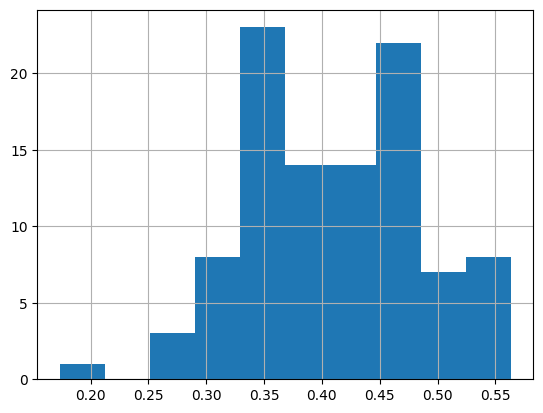

In [8]:
print(matrix_df.mean().mean())
matrix_df.mean().hist()

In [11]:
import numpy as np

df_mean = matrix_df.mean().reset_index()
max_val = np.max(df_mean[0])

best_index = df_mean[df_mean[0]==max_val]
best_index = best_index['Dataset 2'].iloc[1]
best_index = int(best_index)
best_index

55

In [13]:
df_mean

,Dataset 2,0
0,0.0,0.482134
1,1.0,0.452424
2,2.0,0.386475
3,3.0,0.474764
4,4.0,0.477005
...,...,...
95,95.0,0.456425
96,96.0,0.173416
97,97.0,0.466614
98,98.0,0.340889


In [12]:
best_df = list_df[best_index]

In [14]:
df_net = pl.from_pandas(best_df)
df_edge, df_nodes = get_edge_node_table(df_net)

df_edge_filter = df_edge[df_edge["weight"] >= dict_op.min_count_link]
df_edge_filter = df_edge_filter[
    df_edge_filter["source"] != df_edge_filter["target"]
]
df_edge_filter = df_edge_filter[
    df_edge_filter["rank_count"] <= dict_op.n_neighbours
]

df_partition, g = sygma_graph_leiden(
    df_edge_filter,
    df_nodes,
    edge_bins=10,
    node_bins=10,
    filepath='../graph/best_2.html',
)
df_partition = df_partition.sort_values("community")
df_partition


,community,node
0,0,mathematician
1,0,astronomer
2,0,physicist
3,0,musicologist
4,0,meteorologist
5,0,geographer
6,0,geologist
7,0,chemist
13,1,anthropologist
12,1,archeologist
